# Intro

I called this "numpig" because it's one specific example of a numpy map-reduce approach that somewhat whimsically called to mind for me the image of a python eating multiple pigs (or maybe that's gruesomely). The ideas is to squeeze big memory requests sequentially through limited available memory. It also hogs memory for this use case compared to a more efficient space partitioning approach (see below). This could be improved slightly using a `triu_indices` rather than `meshgrid` approach (also demonstrated). In any case, I'm keeping it for the whimsy.

# Problem definition

We want to find concident points (to some precision) from a collection of points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

num_points = 10
coincident_precision = 0.2

def dist(a, b):
  d = b - a
  return np.hypot(d[...,0], d[...,1])

def coincident(a, b):
  return dist(a, b) < coincident_precision

xs = np.random.uniform(0, 1, num_points)
ys = np.random.uniform(0, 1, num_points)

points = np.stack((xs, ys), axis=1)

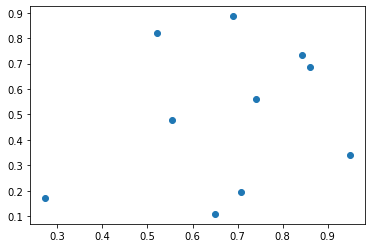

In [2]:
plt.scatter(xs, ys)
plt.show()

# Process the whole array in one chunk

First cut brute force. Evalute all pairs in a big pairwise array. Requires lots of memory but simple and fast. 

NB. With "upper" (triangular), we're eliminating any results on or below the diagonal as they are trivial results or duplicates.

In [3]:
def coincident_points(ps):
  p_ids = np.arange(ps.shape[0])
  pi, pj = np.meshgrid(p_ids, p_ids)
  all_coincident = coincident(ps[pi], ps[pj])
  coincident_ids = np.argwhere(all_coincident)
  return coincident_ids

def upper_ids(c_ids):
  return c_ids[np.nonzero(c_ids[:,1] - c_ids[:,0] > 0)]

def upper_coincident_points(ps):
  return upper_ids(coincident_points(ps))

In [4]:
uc = upper_coincident_points(points)

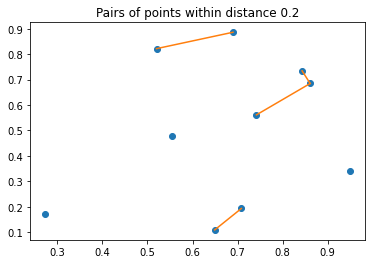

In [5]:
plt.scatter(xs, ys)
for i in range(uc.shape[0]):
  plt.plot([xs[uc[i,0]], xs[uc[i,1]]], [ys[uc[i,0]], ys[uc[i,1]]], color='tab:orange')
plt.title(f'Pairs of points within distance {coincident_precision}')
plt.show()

# Sequentially process chunks of array that fit in memory

Eventually, as `num_points` scales, we run out of memory. (Try 20000 if running in base Colab instance.)

To fit in limited memory, we break the big array into chunks and process them sequentially, then reassemble the output list. Still brute force, but note that as we're only keeping "upper" (triangular) results, we needn't process chunks below the diagonal.

In [6]:
def num_chunks(dim, max_dim):
  chunks = dim // max_dim
  chunks = chunks + (1 if dim % max_dim > 0 else 0)
  return chunks

def splits(a, max_dim):
  chunks = num_chunks(a.shape[0], max_dim)
  return np.array_split(a, chunks)

In [7]:
def upper_coincident_points_chunk(ps, si, sj, ax=None):
  pi, pj = np.meshgrid(sj, si)
  c = coincident(ps[pi], ps[pj])
  ## visualisation code
  ax.imshow(c, vmin=0, vmax=1)
  ax.axis('off')
  ##
  c_ids = np.argwhere(c)
  c_ids[:,0] = c_ids[:,0] + si[0]
  c_ids[:,1] = c_ids[:,1] + sj[0]
  return upper_ids(c_ids)

def upper_coincident_points_split(ps, max_dim):
  p_ids = np.arange(ps.shape[0])
  id_splits = splits(p_ids, max_dim)
  ## visualisation code
  fig, ax = plt.subplots(len(id_splits), len(id_splits))
  ##
  all_coincident_ids = []

  for i in range(len(id_splits)):
    for j in range(i, len(id_splits)):     
      uc_ids = upper_coincident_points_chunk(ps, id_splits[i], id_splits[j], ax=ax[i,j])
      all_coincident_ids.extend([tuple(uc) for uc in uc_ids])

  ## visualisation code
  for i in range(len(id_splits)):
    for j in range(i):     
      ax[i,j].axis('off')
  fig.suptitle('numpig array map reduce')
  plt.show()
  ##

  return np.array(sorted(all_coincident_ids))

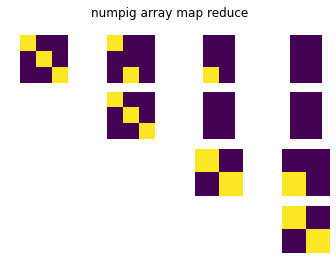

In [8]:
split_uc = upper_coincident_points_split(points, 3)

# Compare the results

In [9]:
delta = split_uc - uc
np.amax(delta), np.amin(delta)

(0, 0)

# Better exploiting symmetry

Because distance is symmetrical, we needn't process anything below the diagonal. This approach uses `triu_indices` instead of `meshgrid` but we need an inverse method to find row and column from index of trui_indicies array

In [10]:
def coincident_points_triu(ps):
  pi, pj = np.triu_indices(ps.shape[0], k=1)
  all_coincident = coincident(ps[pi], ps[pj])
  coincident_ids = np.argwhere(all_coincident).flatten()
  return coincident_ids

This method straightforward (?) to understand for a single index

In [11]:
def triu_rowcol(n, i, k=0):
  rowcum = np.cumsum(np.flip(np.arange(1, n - k + 1)))
  if i >= rowcum[-1]:
    raise IndexError("triangular index out of range")
  row = np.argwhere(rowcum > i).flatten()[0]
  col = i + (row + k) - (rowcum[row - 1] if row > 0 else 0)
  return row, col

But not super neat for vectorising

In [12]:
uti = coincident_points_triu(points)
utp1 = np.array([triu_rowcol(points.shape[0], i, k=1) for i in uti])

In [13]:
delta = utp1 - uc
np.amax(delta), np.amin(delta)

(0, 0)

This alternative method relies on the quadratic form of index by row, neater for vecotrising

In [14]:
def triu_row_array(n, i):
  if np.max(i) >= n * (n + 1) // 2:
    raise IndexError("triangular index out of range")
  b = -(2 * n + 1)
  c = 2 * np.atleast_1d(i)
  det = b * b - 4 * c
  return ((-b - np.sqrt(det)) / 2).astype(int)

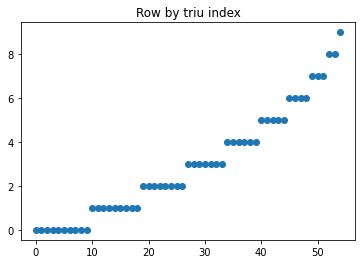

In [15]:
plt.plot(np.arange(55), triu_row_array(10, np.arange(55)), 'o')
plt.title('Row by triu index')
plt.show()

In [16]:
def triu_rowcol_array(n, i, k=0):
  rows = triu_row_array(n - k, i)
  i_rows = rows * (2 * (n - k) + 1 - rows) // 2
  cols = i - i_rows + rows + k
  return np.stack((rows, cols), axis=-1)

In [17]:
utp2 = triu_rowcol_array(points.shape[0], uti, k=1)

In [18]:
delta = utp2 - uc
np.amax(delta), np.amin(delta)

(0, 0)

A third method using combinations, only valid for `k = 1` case of `triu_indices`, but extensible to more than 2 dimensions

In [19]:
import itertools as it

def triu_indices_combn(n, d=2):
  c = it.combinations(range(n), d)
  return tuple([np.array(i) for i in zip(*c)])

def triu_rowcol_combn(n, i, d=2):
  c = it.combinations(range(n), d)
  for j, v in enumerate(c):
    if j == i:
      return v

In [20]:
np.triu_indices(3, k=1), triu_indices_combn(3)

((array([0, 0, 1]), array([1, 2, 2])), (array([0, 0, 1]), array([1, 2, 2])))

In [21]:
utp3 = np.array([triu_rowcol_combn(points.shape[0], i) for i in uti])

In [22]:
delta = utp3 - uc
np.amax(delta), np.amin(delta)

(0, 0)

# Even better solution

In this case is a space partitioning method like https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html, which is faster still than "numpig" and hogs far less memory, but decided to keep this notebook anyway for the maths whimsy.

In [23]:
from scipy.spatial import KDTree

kd_uc = KDTree(points).query_pairs(coincident_precision)

In [24]:
delta_2 = np.array(sorted(list(kd_uc))) - uc
np.amax(delta_2), np.amin(delta_2)

(0, 0)